In [1]:
%load_ext autoreload
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from postamats.utils import load, helpers
from postamats.utils.connections import PATH_TO_ROOT, DB
from postamats.global_constants import ALL_METRO_NAME, OBJECT_ID_METRO_COL, ALL_OBJECTS_NAME, OBJECT_ID_COL,\
    CENTER_MASS_ID_COL, CENTER_MASS_NAME, METERS_TO_SEC_COEF

pd.set_option('display.max_columns', None)

In [2]:
# рассчитаем коэффициент перевода метров во время ходьбы
walk_time_500 = [10,9,11,10,10,11,9,9,9,8]
walk_speed = 500 / (60 * np.mean([10,9,11,10,10,11,9,9,9,8]))
meters_to_sec_coef = 1 / walk_speed
print(meters_to_sec_coef, 'сек/м')

1.152 сек/м


In [3]:
CONFIG_PATH = os.path.join(PATH_TO_ROOT, 'db_config.json')
with open(CONFIG_PATH, mode='r') as db_file:
    db_config = json.load(db_file)
database = DB(db_config)

In [4]:
cm_data = database.get_table_from_bd(CENTER_MASS_NAME)

Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [5]:
cm_data[cm_data['lat'].isna() | cm_data['lon'].isna()]

,id_center_mass,lat,lon,population,step


In [6]:
ojb_data = database.get_table_from_bd(ALL_OBJECTS_NAME)

Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [7]:
ojb_data[ojb_data['lat'].isna() | ojb_data['lon'].isna()]

,object_id,adm_area,district,object_type,lat,lon,address


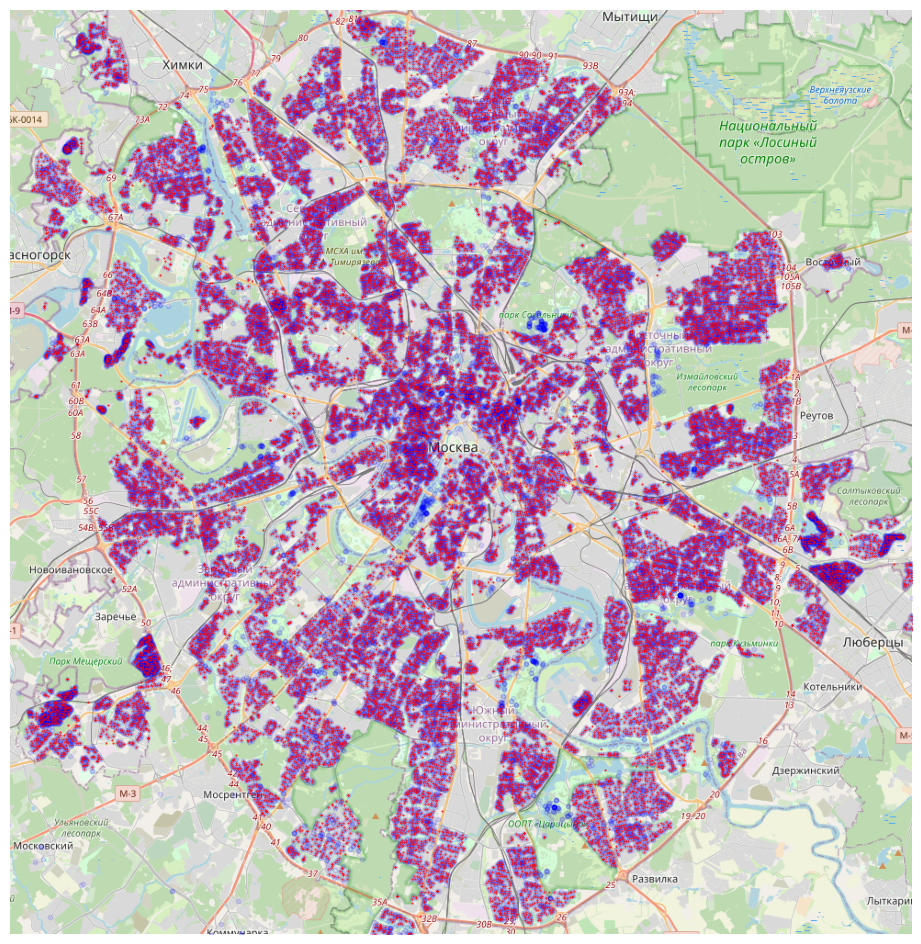

In [8]:
mos_img = plt.imread(os.path.join(PATH_TO_ROOT, 'data', 'images', 'map.png'))

bbox_geo = (37.3260, 37.9193, 55.5698, 55.9119)
bbox_cartes = helpers.calc_cartesian_coords(bbox_geo[2:], bbox_geo[:2])
bbox = bbox_cartes['x'].to_list() + bbox_cartes['y'].to_list()

cm_points_coords = helpers.calc_cartesian_coords(cm_data['lat'], cm_data['lon'])
obj_points_coords = helpers.calc_cartesian_coords(ojb_data['lat'], ojb_data['lon'])

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(obj_points_coords['x'], obj_points_coords['y'], zorder=1, alpha=0.1, c='b', s=10)
ax.scatter(cm_points_coords['x'], cm_points_coords['y'], zorder=1, alpha=1, c='r', s=.2)

ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.axis('off')
ax.imshow(mos_img, zorder=0, extent=bbox, aspect='equal')
plt.show()

Пайплайн расчета матрицы дистанций на стороне БД

In [23]:
# load.calc_distances_matrix_database(CONFIG_PATH)

Connection to PostgreSQL DB successful
Connection to PostgreSQL DB successful
Connection to PostgreSQL DB successful


DatabaseError: could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out


Пайплайн расчета матрицы дистанций локально

In [10]:
all_dists_metro = load.calc_distances_matrix_locally(
    CONFIG_PATH,
    table1=ALL_OBJECTS_NAME,
    id1_col=OBJECT_ID_COL,
    table2=ALL_METRO_NAME,
    id2_col=OBJECT_ID_METRO_COL,
    meters_to_sec_coef=METERS_TO_SEC_COEF
    )

Загружаем из БД all_objects_data
Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Загружаем из БД all_metro_objects_data
Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


include_houses = False, многоквартирные дома будут исключены из рассчета расстояний.
Размер картезианова датафрейма: 5160 x 1787 = 9220920.
Датафрейм будет разбит на 1 частей
Получаем картезиановы датафреймы для каждой части:


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Считаем расстояния:


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Объединяем срезы ... успешно


In [11]:
display(all_dists_metro.head())
print(all_dists_metro.shape)

,object_id,object_id_metro,distance,walk_time
0,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,cb102f6b9d341d9fdc1a4571088a7d91d29862167c76e8...,11834,13633
1,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,1c99788b270f0a957fed01e194ea9f9abab54a536109b2...,20026,23070
2,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,9355e0e2f696e3562ac04a1df34b786912ce2d00f75ba4...,10304,11870
3,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,36d333776dfcb9d4b139584ba6183b2df25d0d7e6fde99...,28143,32421
4,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,4647f51e2a77a555354ed313104a885d4911a4bb4b4689...,24664,28413


(9220920, 4)


In [12]:
all_dists = load.calc_distances_matrix_locally(
    CONFIG_PATH,
    table1=ALL_OBJECTS_NAME,
    id1_col=OBJECT_ID_COL,
    table2=CENTER_MASS_NAME,
    id2_col=CENTER_MASS_ID_COL,
    meters_to_sec_coef=METERS_TO_SEC_COEF
)

Загружаем из БД all_objects_data
Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Загружаем из БД centers_mass
Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


include_houses = False, многоквартирные дома будут исключены из рассчета расстояний.
Размер картезианова датафрейма: 5160 x 29018 = 149732880.
Датафрейм будет разбит на 15 частей
Получаем картезиановы датафреймы для каждой части:


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Считаем расстояния:


100%|██████████| 15/15 [00:27<00:00,  1.86s/it]


Объединяем срезы ... успешно


In [13]:
display(all_dists.head())
print(all_dists.shape)

,object_id,id_center_mass,distance,walk_time
0,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,61634_23649_0.1,31271,36024
1,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,61635_23649_0.1,31226,35972
2,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,61635_23650_0.1,31187,35927
3,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,61635_23651_0.1,31155,35891
4,b819ec2781bebd714e39a3e9d0133709397868b238d6e7...,61636_23649_0.1,31082,35806


(149732880, 4)


In [16]:
all_dists_metro_filtered = all_dists_metro[all_dists_metro['walk_time'] < 40 * 60]
all_dists_filtered = all_dists[all_dists['walk_time'] < 40 * 60]

In [17]:
database.load_to_bd(all_dists_filtered, 'distances_matrix_filter')

In [18]:
database.load_to_bd(all_dists_metro_filtered, 'distances_matrix_metro_filter')

In [21]:
database.load_to_bd(all_dists_metro, 'distances_matrix_metro')

In [ ]:
# database.load_to_bd(all_dists, 'distances_matrix')